In [1]:
from __future__ import division
import random,pickle,csv,cv2,os,scipy,pickle,warnings,matplotlib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.stats import norm,skew
from itertools import islice

import keras.backend as K
from keras.callbacks import History
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,GlobalMaxPooling2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.applications.mobilenet_v2 import MobileNetV2
#from keras.utils import print_summary
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from keras.optimizers import Adam,SGD
from keras import applications
from keras.utils.vis_utils import plot_model

#print(os.listdir('../input/self driving car training data/data'))
warnings.filterwarnings('ignore')

2023-05-26 13:20:41.091539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 13:20:42.321050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/envs/fibered/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-26 13:20:42.321092: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-26 13:20:44.767100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.

In [11]:
import numpy as np

A = np.array([[[1,2,3], [4,5,6], [7,8,9]], [[0,1,0], [-1,-1, 2], [-5,-4,-3]]])
A[:,:,::-1]
#A

array([[[ 3,  2,  1],
        [ 6,  5,  4],
        [ 9,  8,  7]],

       [[ 0,  1,  0],
        [ 2, -1, -1],
        [-3, -4, -5]]])

In [13]:
B= np.append(A, A[:, :, ::-1], axis=0  )
B

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[ 0,  1,  0],
        [-1, -1,  2],
        [-5, -4, -3]],

       [[ 3,  2,  1],
        [ 6,  5,  4],
        [ 9,  8,  7]],

       [[ 0,  1,  0],
        [ 2, -1, -1],
        [-3, -4, -5]]])

In [4]:
B = np.append(A, A[:, ::-1], axis=1)
B

array([[1, 2, 3, 3, 2, 1],
       [4, 5, 6, 6, 5, 4],
       [7, 8, 9, 9, 8, 7]])

In [2]:
A[::-1, :]

array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
def image_preprocessing(img):
    resized_image = cv2.resize((cv2.cvtColor(img,cv2.COLOR_RGB2HSV))[:,:,1],(40,40))
    return resized_image

In [4]:
def load_training(delta):
    logs = []
    features = []
    labels = []
    with open(labels_file,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
        
    for i in range(len(logs)):
        for j in range(3):
            img_path = logs[i][j]
            img_path = features_directory + 'IMG' + (img_path.split('IMG')[1]).strip()
            img = plt.imread(img_path)
            features.append(image_preprocessing(img))
            
            if j == 0:
                labels.append(float(logs[i][3]))
            elif j == 1:
                labels.append(float(logs[i][3]) + delta)
            else:
                labels.append(float(logs[i][3]) - delta)
    return features,labels

In [5]:
def loadFromPickle():
    with open('features','rb') as f:
        features = np.array(pickle.load(f))
    with open('labels','rb') as f:
        labels = np.array(pickle.load(f))
    return features,labels

def augmentData(features,labels):
    features = np.append(features,features[:,:,::-1],axis=0)
    labels = np.append(labels,-labels,axis=0)
    return features,labels

In [9]:
import graphviz
print(graphviz.__version__)

0.20.1


In [19]:
features_directory = 'self_driving_data/'
#features_directory = '../input/self driving car training data/data/'
labels_file = 'self_driving_data/driving_log.csv'

In [20]:
delta = 0.2
features,labels = load_training(delta)

features = np.array(features).astype('float32')
labels = np.array(labels).astype('float32')

with open('features','wb') as f:
    pickle.dump(features,f,protocol=4)
with open('labels','wb') as f:
    pickle.dump(labels,f,protocol=4)

In [21]:
pan = pd.Panel(features)
df = pan.swapaxes(1,2).to_frame()
df.index = df.index.droplevel('major')
df.index = df.index+1

AttributeError: module 'pandas' has no attribute 'Panel'

In [6]:
features,labels = loadFromPickle()
features,labels = shuffle(features,labels)

x_train,x_val,y_train,y_val = train_test_split(features,labels,random_state=42,test_size=0.2)

x_train = x_train.reshape(x_train.shape[0],40,40,1)
x_val = x_val.reshape(x_val.shape[0],40,40,1)

2023-05-26 13:21:31.706750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/envs/fibered/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-26 13:21:31.706967: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-26 13:21:31.707085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-88TBBTR): /proc/driver/nvidia/version does not exist
2023-05-26 13:21:31.708068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_40 (Functi  (None, 2, 2, 1280)       2257408   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,258,689
Trainable params: 1,281
Non-trainable params: 2,257,408
_________________________________________________________________


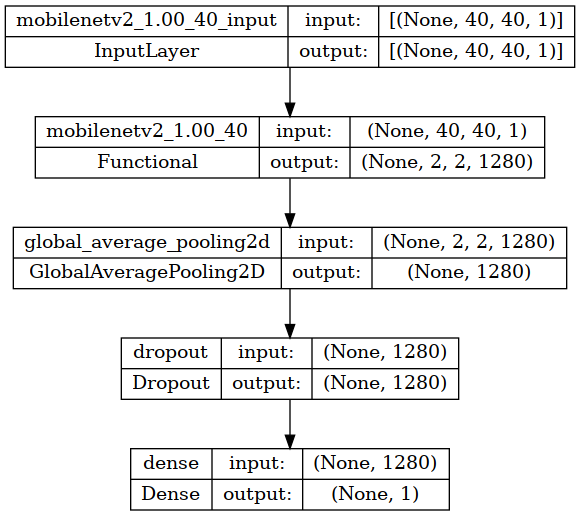

In [7]:
base_model = MobileNetV2(include_top=False,weights=None,input_shape=(40,40,1))

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [9]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
    
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs = 50, 
    verbose = 1,
    callbacks=callbacks,
    batch_size = 256
)

2023-05-26 13:22:49.306192: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 123430400 exceeds 10% of free system memory.


Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.1830
Epoch 1: val_loss improved from inf to 0.65200, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 80s 973ms/step - loss: 0.6711 - accuracy: 0.1830 - val_loss: 0.6520 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.6347 - accuracy: 0.1830
Epoch 2: val_loss improved from 0.65200 to 0.61675, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 68s 903ms/step - loss: 0.6347 - accuracy: 0.1830 - val_loss: 0.6167 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.1830
Epoch 3: val_loss improved from 0.61675 to 0.58295, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 71s 941ms/step - loss: 0.6002 - accuracy: 0.1830 - val_loss: 0.5829 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 4/50
76/76 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.1830
Epoch 4: val_loss improved from 0.58295 to 0.55056, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 70s 931ms/step - loss: 0.5671 - accuracy: 0.1830 - val_loss: 0.5506 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 5/50
76/76 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.1830
Epoch 5: val_loss improved from 0.55056 to 0.51958, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 65s 866ms/step - loss: 0.5355 - accuracy: 0.1830 - val_loss: 0.5196 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 6/50
76/76 [==============================] - ETA: 0s - loss: 0.5053 - accuracy: 0.1830
Epoch 6: val_loss improved from 0.51958 to 0.48994, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 63s 840ms/step - loss: 0.5053 - accuracy: 0.1830 - val_loss: 0.4899 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 7/50
76/76 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.1830
Epoch 7: val_loss improved from 0.48994 to 0.46179, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 47s 625ms/step - loss: 0.4764 - accuracy: 0.1830 - val_loss: 0.4618 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 8/50
76/76 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.1830
Epoch 8: val_loss improved from 0.46179 to 0.43487, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 511ms/step - loss: 0.4489 - accuracy: 0.1830 - val_loss: 0.4349 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 9/50
76/76 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.1830
Epoch 9: val_loss improved from 0.43487 to 0.40921, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 513ms/step - loss: 0.4226 - accuracy: 0.1830 - val_loss: 0.4092 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 10/50
76/76 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.1830
Epoch 10: val_loss improved from 0.40921 to 0.38490, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 38s 507ms/step - loss: 0.3977 - accuracy: 0.1830 - val_loss: 0.3849 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 11/50
76/76 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.1830
Epoch 11: val_loss improved from 0.38490 to 0.36183, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 511ms/step - loss: 0.3741 - accuracy: 0.1830 - val_loss: 0.3618 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 12/50
76/76 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.1830
Epoch 12: val_loss improved from 0.36183 to 0.33991, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 41s 547ms/step - loss: 0.3516 - accuracy: 0.1830 - val_loss: 0.3399 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 13/50
76/76 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.1830
Epoch 13: val_loss improved from 0.33991 to 0.31921, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 68s 902ms/step - loss: 0.3303 - accuracy: 0.1830 - val_loss: 0.3192 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 14/50
76/76 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.1830
Epoch 14: val_loss improved from 0.31921 to 0.29960, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 49s 648ms/step - loss: 0.3102 - accuracy: 0.1830 - val_loss: 0.2996 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 15/50
76/76 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.1830
Epoch 15: val_loss improved from 0.29960 to 0.28111, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 48s 638ms/step - loss: 0.2912 - accuracy: 0.1830 - val_loss: 0.2811 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 16/50
76/76 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.1830
Epoch 16: val_loss improved from 0.28111 to 0.26370, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 50s 656ms/step - loss: 0.2733 - accuracy: 0.1830 - val_loss: 0.2637 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 17/50
76/76 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.1830
Epoch 17: val_loss improved from 0.26370 to 0.24721, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 46s 616ms/step - loss: 0.2564 - accuracy: 0.1830 - val_loss: 0.2472 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 18/50
76/76 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.1830
Epoch 18: val_loss improved from 0.24721 to 0.23176, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 50s 666ms/step - loss: 0.2405 - accuracy: 0.1830 - val_loss: 0.2318 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 19/50
76/76 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.1830
Epoch 19: val_loss improved from 0.23176 to 0.21717, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 509ms/step - loss: 0.2254 - accuracy: 0.1830 - val_loss: 0.2172 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 20/50
76/76 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.1830
Epoch 20: val_loss improved from 0.21717 to 0.20350, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 37s 493ms/step - loss: 0.2114 - accuracy: 0.1830 - val_loss: 0.2035 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 21/50
76/76 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.1830
Epoch 21: val_loss improved from 0.20350 to 0.19067, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 37s 496ms/step - loss: 0.1982 - accuracy: 0.1830 - val_loss: 0.1907 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 22/50
76/76 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.1830
Epoch 22: val_loss improved from 0.19067 to 0.17859, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 46s 615ms/step - loss: 0.1858 - accuracy: 0.1830 - val_loss: 0.1786 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 23/50
76/76 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.1830
Epoch 23: val_loss improved from 0.17859 to 0.16732, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 42s 559ms/step - loss: 0.1742 - accuracy: 0.1830 - val_loss: 0.1673 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 24/50
76/76 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.1830
Epoch 24: val_loss improved from 0.16732 to 0.15677, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 40s 524ms/step - loss: 0.1633 - accuracy: 0.1830 - val_loss: 0.1568 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 25/50
76/76 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.1830
Epoch 25: val_loss improved from 0.15677 to 0.14688, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 38s 510ms/step - loss: 0.1531 - accuracy: 0.1830 - val_loss: 0.1469 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 26/50
76/76 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.1830
Epoch 26: val_loss improved from 0.14688 to 0.13769, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 43s 571ms/step - loss: 0.1436 - accuracy: 0.1830 - val_loss: 0.1377 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 27/50
76/76 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.1830
Epoch 27: val_loss improved from 0.13769 to 0.12908, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 40s 529ms/step - loss: 0.1348 - accuracy: 0.1830 - val_loss: 0.1291 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 28/50
76/76 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.1830
Epoch 28: val_loss improved from 0.12908 to 0.12107, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 41s 542ms/step - loss: 0.1265 - accuracy: 0.1830 - val_loss: 0.1211 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 29/50
76/76 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.1830
Epoch 29: val_loss improved from 0.12107 to 0.11351, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 44s 587ms/step - loss: 0.1188 - accuracy: 0.1830 - val_loss: 0.1135 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 30/50
76/76 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.1830
Epoch 30: val_loss improved from 0.11351 to 0.10658, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 47s 626ms/step - loss: 0.1116 - accuracy: 0.1830 - val_loss: 0.1066 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 31/50
76/76 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.1830
Epoch 31: val_loss improved from 0.10658 to 0.10002, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 48s 633ms/step - loss: 0.1048 - accuracy: 0.1830 - val_loss: 0.1000 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 32/50
76/76 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.1830
Epoch 32: val_loss improved from 0.10002 to 0.09403, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 48s 641ms/step - loss: 0.0987 - accuracy: 0.1830 - val_loss: 0.0940 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 33/50
76/76 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.1830
Epoch 33: val_loss improved from 0.09403 to 0.08846, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 48s 637ms/step - loss: 0.0929 - accuracy: 0.1830 - val_loss: 0.0885 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 34/50
76/76 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.1830
Epoch 34: val_loss improved from 0.08846 to 0.08320, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 48s 642ms/step - loss: 0.0875 - accuracy: 0.1830 - val_loss: 0.0832 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 35/50
76/76 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.1830
Epoch 35: val_loss improved from 0.08320 to 0.07841, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 46s 608ms/step - loss: 0.0826 - accuracy: 0.1830 - val_loss: 0.0784 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 36/50
76/76 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.1830
Epoch 36: val_loss improved from 0.07841 to 0.07391, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 41s 540ms/step - loss: 0.0780 - accuracy: 0.1830 - val_loss: 0.0739 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 37/50
76/76 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.1830
Epoch 37: val_loss improved from 0.07391 to 0.06975, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 510ms/step - loss: 0.0737 - accuracy: 0.1830 - val_loss: 0.0698 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 38/50
76/76 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.1830
Epoch 38: val_loss improved from 0.06975 to 0.06591, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 40s 526ms/step - loss: 0.0697 - accuracy: 0.1830 - val_loss: 0.0659 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 39/50
76/76 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.1830
Epoch 39: val_loss improved from 0.06591 to 0.06240, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 512ms/step - loss: 0.0661 - accuracy: 0.1830 - val_loss: 0.0624 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 40/50
76/76 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.1830
Epoch 40: val_loss improved from 0.06240 to 0.05910, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 515ms/step - loss: 0.0627 - accuracy: 0.1830 - val_loss: 0.0591 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 41/50
76/76 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.1830
Epoch 41: val_loss improved from 0.05910 to 0.05607, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 515ms/step - loss: 0.0596 - accuracy: 0.1830 - val_loss: 0.0561 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 42/50
76/76 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.1830
Epoch 42: val_loss improved from 0.05607 to 0.05321, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 513ms/step - loss: 0.0568 - accuracy: 0.1830 - val_loss: 0.0532 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 43/50
76/76 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.1830
Epoch 43: val_loss improved from 0.05321 to 0.05069, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 38s 509ms/step - loss: 0.0541 - accuracy: 0.1830 - val_loss: 0.0507 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 44/50
76/76 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.1830
Epoch 44: val_loss improved from 0.05069 to 0.04834, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 514ms/step - loss: 0.0517 - accuracy: 0.1830 - val_loss: 0.0483 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 45/50
76/76 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.1830
Epoch 45: val_loss improved from 0.04834 to 0.04614, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 516ms/step - loss: 0.0495 - accuracy: 0.1830 - val_loss: 0.0461 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 46/50
76/76 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.1830
Epoch 46: val_loss improved from 0.04614 to 0.04418, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 40s 529ms/step - loss: 0.0474 - accuracy: 0.1830 - val_loss: 0.0442 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 47/50
76/76 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.1830
Epoch 47: val_loss improved from 0.04418 to 0.04241, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 515ms/step - loss: 0.0456 - accuracy: 0.1830 - val_loss: 0.0424 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 48/50
76/76 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.1830
Epoch 48: val_loss improved from 0.04241 to 0.04078, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 39s 517ms/step - loss: 0.0439 - accuracy: 0.1830 - val_loss: 0.0408 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 49/50
76/76 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.1830
Epoch 49: val_loss improved from 0.04078 to 0.03926, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 40s 525ms/step - loss: 0.0424 - accuracy: 0.1830 - val_loss: 0.0393 - val_accuracy: 0.1723 - lr: 0.0010
Epoch 50/50
76/76 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.1830
Epoch 50: val_loss improved from 0.03926 to 0.03792, saving model to ./base.model


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


76/76 [==============================] - 42s 557ms/step - loss: 0.0410 - accuracy: 0.1830 - val_loss: 0.0379 - val_accuracy: 0.1723 - lr: 0.0010


KeyError: 'acc'

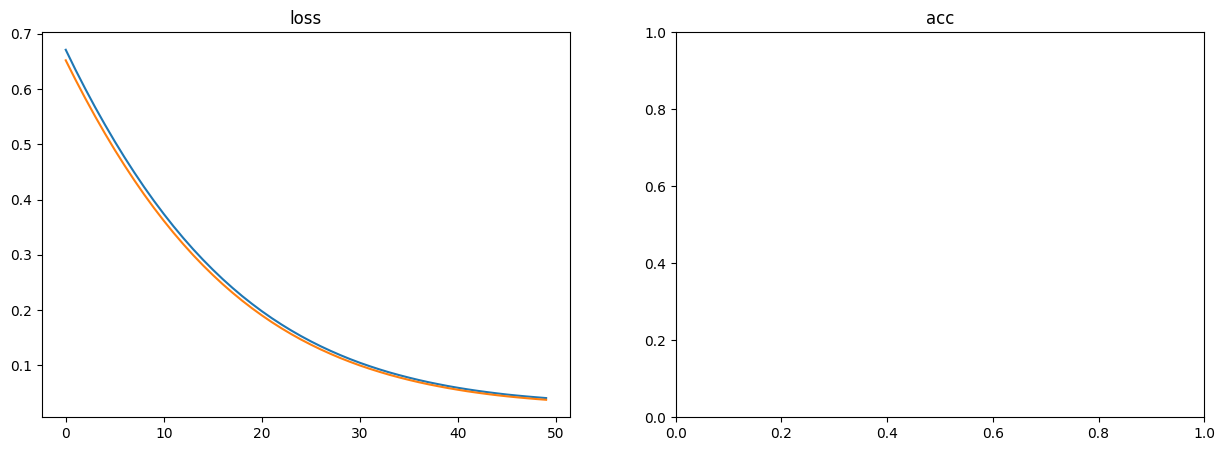

In [10]:
show_final_history(history)
model.load_weights(best_model_weights)

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")
print("JSON Saved")

In [11]:
model.save("model.h5")
print("Weights Saved")
print("JSON Saved")

Weights Saved
JSON Saved
